In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import gymnasium as gym
import numpy as np
import time
import random

# %matplotlib inline

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## **Torch MLP**

In [2]:
class Torch_MLP(nn.Module):
    def __init__(self, layer_dims: list):
        super(Torch_MLP, self).__init__()
        layers = []
        for i in range(len(layer_dims) - 1):
            layers.append(nn.Linear(layer_dims[i], layer_dims[i + 1]))
            if i < len(layer_dims) - 2:  # No ReLU on the output layer
                layers.append(nn.ReLU())
        self.network = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x)

    def print_num_parameters(self):
        total_params = sum(p.numel() for p in self.parameters())
        print(f"Total number of parameters: {total_params}")

class ReplayBuffer:
    def __init__(self, buffer_size: int):
        self.buffer_size = buffer_size
        self.buffer = []

    def add(self, state, action, reward, next_state, done):
        if len(self.buffer) >= self.buffer_size:
            self.buffer.pop(0)
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size: int):
        return random.sample(self.buffer, batch_size)

In [3]:
env = gym.make('LunarLander-v3')

layer_dims = [8, 32, 64, 32, 4]
model = Torch_MLP(layer_dims)
model.print_num_parameters()
model.to(device)

learning_rate = 0.001
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_episodes = 1000
trace = 100
gamma = 0.99

episode_reward_history = []

start = time.time()
for episode in range(num_episodes):
    state, _ = env.reset()
    state = torch.FloatTensor(state).to(device)
    done = False
    episode_reward = 0

    while not done:
        # Forward pass
        q_values = model(state)
        epsilon = max(0.1, 1 - episode / (num_episodes * 0.5))  # Decay lineal
        if np.random.rand() < epsilon:  # Explorar
            action = env.action_space.sample()
        else:  # Explotar
            action = torch.argmax(q_values).item()

        # Take action
        next_state, reward, done, a, b = env.step(action)
        next_state = torch.FloatTensor(next_state).to(device)
        episode_reward += reward

        # Compute target
        with torch.no_grad():
            target = reward + gamma * torch.max(model(next_state)) * (1 - done)
        target = torch.FloatTensor([target]).to(device)

        # Compute loss
        q_value = q_values[action]
        loss = loss_function(q_value, target)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        state = next_state

    episode_reward_history.append(episode_reward)
    
    if (episode + 1) % trace == 0:
        print(f"Episode {episode + 1}, Total Reward: {episode_reward}")

torch.save(model.state_dict(), "lunar_lander_MLP.pt")
minutos, segundos = divmod(time.time()-start, 60)
print(f"*******Tiempo entreno: {int(minutos)} minutos y {segundos:.2f} segundos*******")

Total number of parameters: 4612


c:\Users\aleja\workspace\RLGAN-project-MAADM-UPM\.venv\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode 100, Total Reward: -292.45396851574355
Episode 200, Total Reward: -131.4847687421622
Episode 300, Total Reward: -111.14247504032006
Episode 400, Total Reward: 180.0645492768271
Episode 500, Total Reward: 130.3886797169432
Episode 600, Total Reward: -69.59641849981693
Episode 700, Total Reward: 209.10482893240152
Episode 800, Total Reward: -192.91705142065433
Episode 900, Total Reward: 195.20120246569087
Episode 1000, Total Reward: 211.0386807948305
*******Tiempo entreno: 14 minutos y 17.69 segundos*******


## **Reward history**

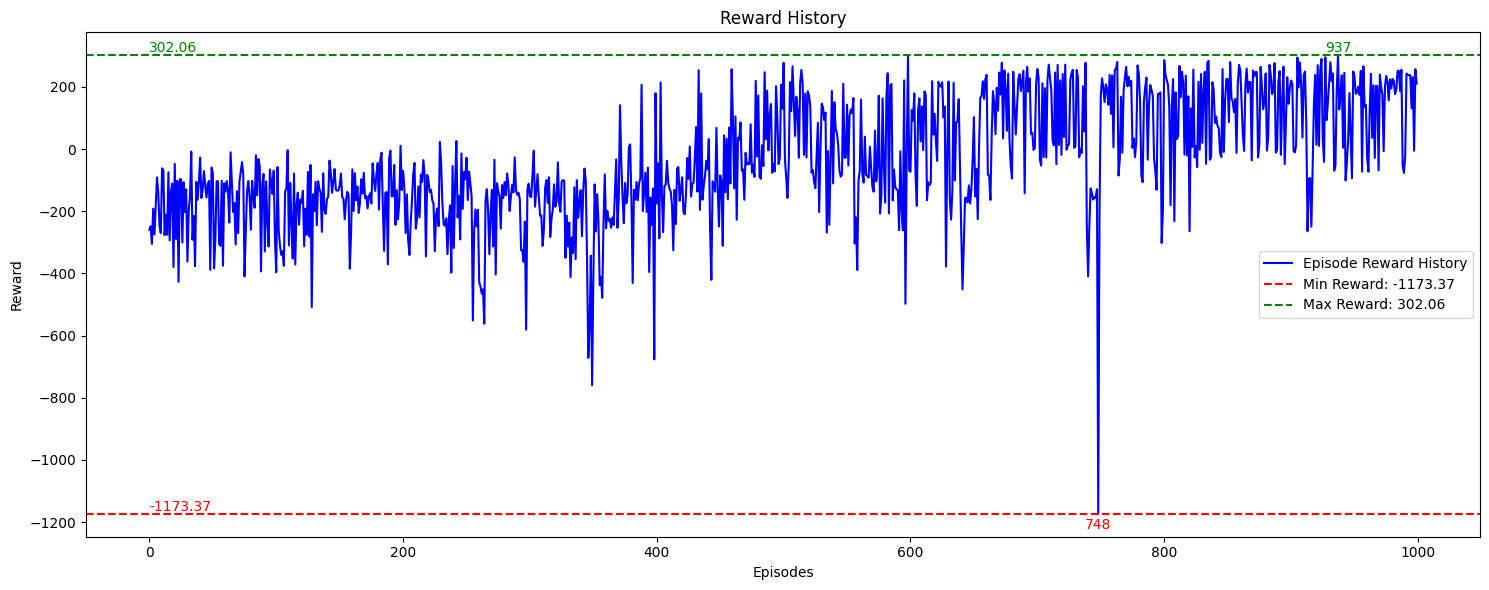

In [26]:
plt.figure(figsize=(15, 6))
plt.plot(num_episodes, episode_reward_history, label='Episode Reward History', color='blue')

# Adding min and max bars
min_reward = min(episode_reward_history)
max_reward = max(episode_reward_history)
min_episode = episode_reward_history.index(min_reward)
max_episode = episode_reward_history.index(max_reward)

plt.axhline(y=min_reward, color='red', linestyle='--', label=f'Min Reward: {min_reward:.2f}')
plt.axhline(y=max_reward, color='green', linestyle='--', label=f'Max Reward: {max_reward:.2f}')

# Annotating min and max values
plt.text(0, min_reward+10, f'{min_reward:.2f}', color='red')
plt.text(0, max_reward+10, f'{max_reward:.2f}', color='green')
plt.text(min_episode, min_reward-50, f'{min_episode}', color='red', ha='center')
plt.text(max_episode, max_reward+10, f'{max_episode}', color='green', ha='center')

plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Reward History')
plt.legend(loc='center right')
plt.tight_layout()
plt.savefig('images/lunar_lander_MLP.png')
plt.show()


## **Test model**

In [6]:
model.load_state_dict(torch.load("lunar_lander_MLP.pt"))
model.eval()

env = gym.make('LunarLander-v3', render_mode='human')
state, _ = env.reset()

epsilon = 0.15
def policy(state, epsilon=epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()  # Explore
    else:
        state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
        with torch.no_grad():  # Disable gradient calculation
            action_values = model(state_tensor)
        return torch.argmax(action_values).item()  # Exploit

num_episodes_test = 5

for episode in range(num_episodes_test):
    state, _ = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        env.render()  # Muestra el entorno
        action = policy(state)  # Selecciona la acción según el modelo
        next_state, reward, done, _, _ = env.step(action)  # Avanza al siguiente paso
        total_reward += reward
        state = next_state
    
    print(f"Episode {episode + 1}: Total Reward = {total_reward}")

env.close()

C:\Users\aleja\AppData\Local\Temp\ipykernel_13856\351816603.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("lunar_lander_MLP.pt"))


Episode 1: Total Reward = 201.0023794277628
Episode 2: Total Reward = 219.0360231293572
Episode 3: Total Reward = 230.1383080705971
